In [2]:
pip install yfinance

In [3]:
pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5b281adc97ab70b8442b36a1849fe3b6d5a31d7102ec7d184e3356485383d2ba
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import ta  # For technical indicators


In [5]:
# Fetching historical stock prices
ticker = 'AAPL'
df = yf.download(ticker, start='2015-01-01', end='2024-12-31')

# Display the first few rows
print(df.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.288584  24.757338  23.848709  24.746230  212818400
2015-01-05  23.604336  24.137516  23.417723  24.057539  257142000
2015-01-06  23.606556  23.866481  23.244437  23.668760  263188400
2015-01-07  23.937569  24.037539  23.704302  23.815381  160423600
2015-01-08  24.857306  24.915067  24.148620  24.266365  237458000


In [6]:
import yfinance as yf
import ta

# Load data
df = yf.download("AAPL", start="2015-01-01", end="2024-12-31")

# Add 50-day Simple Moving Average
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Add RSI - Make sure 'Close' is a Series, not a DataFrame
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()

# Drop NaN rows (from SMA and RSI)
df = df.dropna()

# Preview
df[['Close', 'SMA_50', 'RSI']].head()


[*********************100%***********************]  1 of 1 completed


ValueError: Data must be 1-dimensional, got ndarray of shape (2515, 1) instead

In [7]:
import ta
import pandas as pd

print(f"ta version: {ta.__version__}")
print(f"pandas version: {pd.__version__}")


AttributeError: module 'ta' has no attribute '__version__'

In [8]:
!pip show ta pandas


Name: ta
Version: 0.11.0
Summary: Technical Analysis Library in Python
Home-page: https://github.com/bukosabino/ta
Author: Dario Lopez Padial (Bukosabino)
Author-email: Bukosabino@gmail.com
License: The MIT License (MIT)
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pandas
Required-by: 
---
Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the followi

In [9]:
import importlib.metadata

print("ta version:", importlib.metadata.version("ta"))
print("pandas version:", importlib.metadata.version("pandas"))


ta version: 0.11.0
pandas version: 2.2.2


In [10]:
import yfinance as yf
import pandas as pd
import ta

# Step 1: Download stock data
df = yf.download("AAPL", start="2015-01-01", end="2024-12-31")

# ✅ Step 1.5: Fix 'Close' to ensure it's 1D
df['Close'] = df['Close'].squeeze()

# Step 2: Add SMA
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# ✅ Step 3: Add RSI using correct Series
rsi_input = df['Close']
if isinstance(rsi_input, pd.DataFrame):
    rsi_input = rsi_input.squeeze()  # force 1D

rsi_indicator = ta.momentum.RSIIndicator(close=rsi_input)
df['RSI'] = rsi_indicator.rsi()

# Step 4: Drop rows with NaN values from indicators
df.dropna(inplace=True)

# Step 5: Check output
print(df[['Close', 'SMA_50', 'RSI']].head())


[*********************100%***********************]  1 of 1 completed

Price           Close     SMA_50        RSI
Ticker           AAPL                      
Date                                       
2015-03-16  27.868244  26.642975  51.177420
2015-03-17  28.334389  26.723891  56.042617
2015-03-18  28.653330  26.824871  59.049481
2015-03-19  28.436985  26.921480  56.239249
2015-03-20  28.080132  27.004331  51.855470


In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM: [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [12]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [13]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0242 - val_loss: 0.0018
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 3.1373e-04 - val_loss: 0.0012
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 3.4513e-04 - val_loss: 0.0013
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 3.2840e-04 - val_loss: 0.0026
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 2.8888e-04 - val_loss: 0.0018
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2.7934e-04 - val_loss: 0.0014
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.5718e-04 - val_loss: 0.0030
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 2.9616e-04 - val_loss: 0.0015
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 2.1855e-04 - val_loss: 8.9771e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 2.5815e-04 - val_loss: 0.0018
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 2.0605e-04 - val_loss: 0.0021
Epoch 12/20
61/61 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


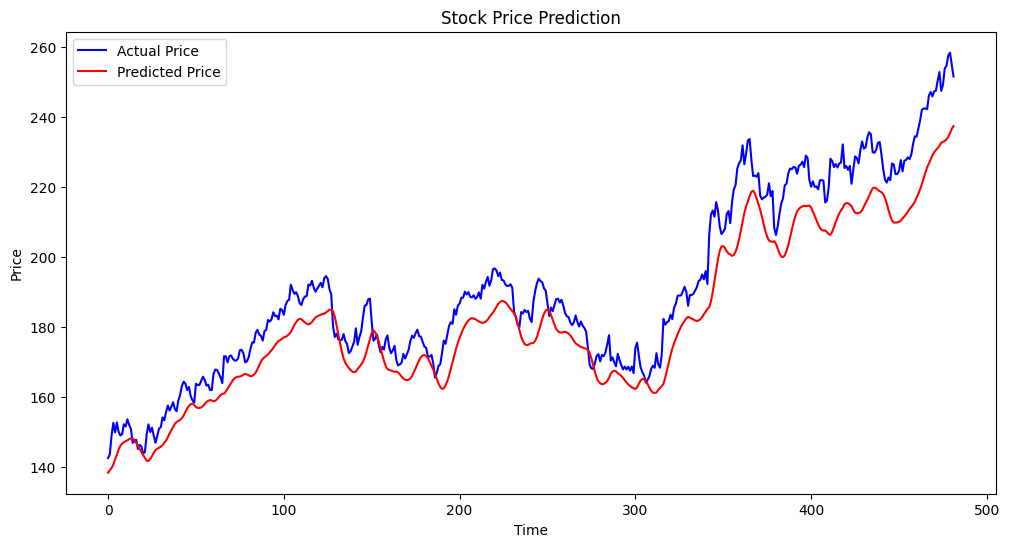

In [15]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(actual, color='blue', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [16]:
model.save('lstm_stock_model.h5')


In [28]:
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' price for prediction
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0132 - val_loss: 7.5689e-04
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 3.5304e-04 - val_loss: 0.0011
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 2.8761e-04 - val_loss: 0.0015
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 2.6473e-04 - val_loss: 0.0013
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 2.9682e-04 - val_loss: 0.0011
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 2.5201e-04 - val_loss: 9.5718e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 2.2851e-04 - val_loss: 6.7536e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 2.7715e-04 - val_loss: 0.0011
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 2.5265e-04 - val_loss: 7.4295e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 2.1583e-04 - val_loss: 5.9530e-04


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


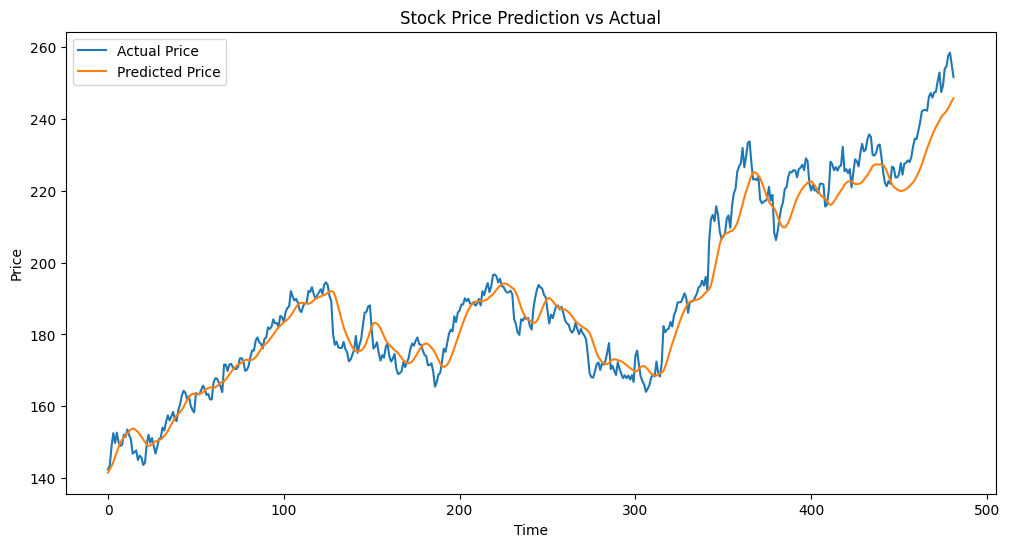

In [31]:
# Predict and inverse transform
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [32]:
model.save("lstm_stock_model.h5")  # Save entire model (recommended)


2025-05-22 03:47:04.566 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:04.567 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:04.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:04.570 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:04.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:04.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:04.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:04.578 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


2025-05-22 03:47:07.208 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:07.711 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:47:07.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

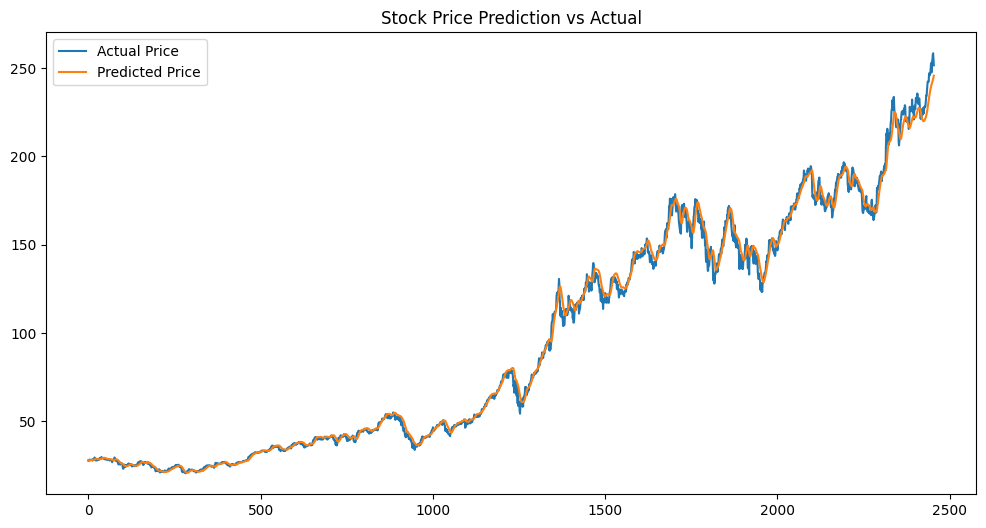

In [33]:
# Save this as app.py and run with `streamlit run app.py`
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

st.title("📈 LSTM Stock Price Predictor")

ticker = st.text_input("Enter Stock Ticker", "AAPL")
start_date = "2015-01-01"
end_date = "2024-12-31"

# Load data
df = yf.download(ticker, start=start_date, end=end_date)
close_data = df[['Close']].values

# Normalize and prepare
scaler = MinMaxScaler()
scaled = scaler.fit_transform(close_data)

window = 60
X = []
for i in range(window, len(scaled)):
    X.append(scaled[i-window:i, 0])
X = np.array(X).reshape(-1, window, 1)

# Load model
model = load_model("lstm_stock_model.h5")
predicted = model.predict(X)
predicted = scaler.inverse_transform(predicted)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(close_data[window:], label='Actual Price')
ax.plot(predicted, label='Predicted Price')
ax.set_title("Stock Price Prediction vs Actual")
ax.legend()
st.pyplot(fig)


In [34]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import ta  # for technical indicators

st.set_page_config(layout="wide")
st.title("📈 LSTM Stock Price Predictor with SMA & RSI")

# --- Sidebar input ---
ticker = st.sidebar.text_input("Enter Stock Ticker", "AAPL")
start_date = st.sidebar.date_input("Start Date", value=pd.to_datetime("2015-01-01"))
end_date = st.sidebar.date_input("End Date", value=pd.to_datetime("2024-12-31"))

# --- Fetch data ---
df = yf.download(ticker, start=start_date, end=end_date)

if df.empty:
    st.warning("No data found. Try a different ticker or date range.")
    st.stop()

# --- Technical Indicators ---
df["SMA_50"] = df["Close"].rolling(window=50).mean()
df["RSI"] = ta.momentum.RSIIndicator(close=df["Close"]).rsi()
df = df.dropna()

# --- Prepare data for LSTM ---
close_prices = df[['Close']].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(close_prices)

window = 60
X = [scaled[i - window:i, 0] for i in range(window, len(scaled))]
X = np.array(X).reshape(-1, window, 1)

# --- Load model ---
try:
    model = load_model("lstm_stock_model.h5")
except:
    st.error("Model file not found. Make sure 'lstm_stock_model.h5' is in the same directory.")
    st.stop()

# --- Predict ---
predicted = model.predict(X)
predicted = scaler.inverse_transform(predicted)

# --- Align predictions with original data ---
df = df.iloc[window:]
df["Predicted_Close"] = predicted

# --- Plotting ---
st.subheader(f"{ticker} Stock Price with LSTM Predictions")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df["Close"], label="Actual Close")
ax.plot(df.index, df["Predicted_Close"], label="Predicted Close")
ax.plot(df.index, df["SMA_50"], label="SMA 50", linestyle="--")
ax.set_title(f"{ticker} Price Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
st.pyplot(fig)

# --- RSI Plot ---
st.subheader("Relative Strength Index (RSI)")
fig2, ax2 = plt.subplots(figsize=(14, 3))
ax2.plot(df.index, df["RSI"], label="RSI", color='purple')
ax2.axhline(70, linestyle='--', color='red', label="Overbought")
ax2.axhline(30, linestyle='--', color='green', label="Oversold")
ax2.set_title("RSI Indicator")
ax2.legend()
st.pyplot(fig2)


2025-05-22 03:48:01.720 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:48:01.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:48:01.725 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:48:01.726 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:48:01.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:48:01.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:48:01.729 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 03:48:01.730 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

ValueError: Data must be 1-dimensional, got ndarray of shape (2515, 1) instead

In [37]:
# --- Technical Indicators ---
from ta.momentum import RSIIndicator

# Fix: Ensure 'Close' is a 1D Series using squeeze()
close_series = df[["Close"]].squeeze()

# Calculate 50-day SMA
df["SMA_50"] = close_series.rolling(window=50).mean()

# Calculate RSI
rsi = RSIIndicator(close=close_series)
df["RSI"] = rsi.rsi()

# Drop NaN values caused by indicators
df = df.dropna()


In [38]:
from sklearn.preprocessing import MinMaxScaler

# Use only the 'Close' price for prediction
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [39]:
# Create sequences for LSTM
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Train-Test Split (80-20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0190 - val_loss: 0.0019
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 4.9845e-04 - val_loss: 8.4326e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 2.8878e-04 - val_loss: 0.0018
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 3.1309e-04 - val_loss: 0.0021
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 2.7121e-04 - val_loss: 0.0014
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 3.2601e-04 - val_loss: 0.0010
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.8343e-04 - val_loss: 0.0011
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 2.6169e-04 - val_loss: 0.0013
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 2.3252e-04 - val_loss: 7.4555e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.5652e-04 - val_loss: 8.2441e-04


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


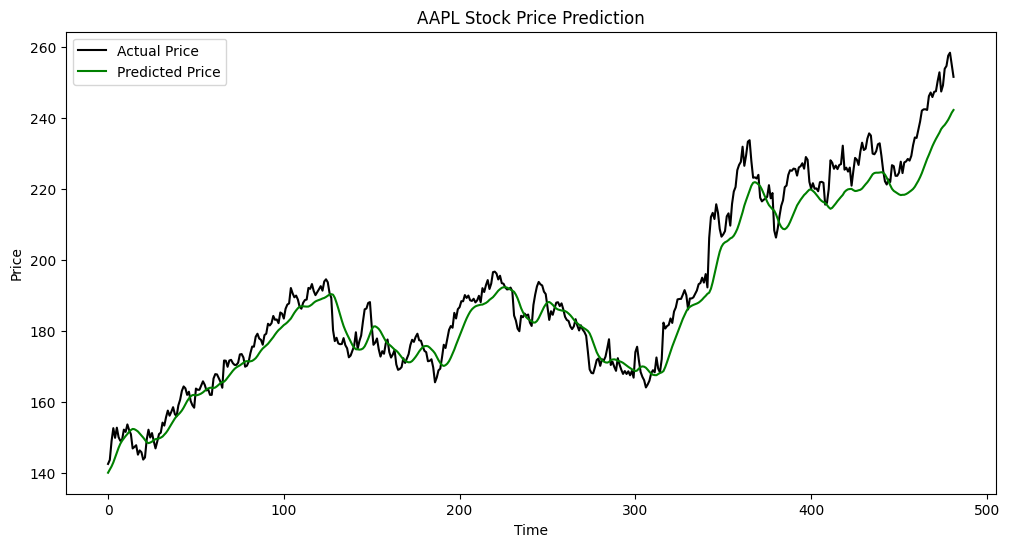

In [42]:
# Make predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_prices, color='green', label='Predicted Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [43]:
model.save('lstm_stock_model.h5')  # Save the model


In [129]:
# app.py
import streamlit as st
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

st.title("📈 AAPL Stock Price Prediction")

# Load model
model = load_model('lstm_stock_model.h5')

# Load data
df = yf.download("AAPL", start="2015-01-01", end="2024-12-31")
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
seq_len = 60
X_test = []
for i in range(seq_len, len(scaled_data)):
    X_test.append(scaled_data[i - seq_len:i, 0])
X_test = np.array(X_test).reshape(-1, seq_len, 1)

# Predict
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# Plot
fig, ax = plt.subplots()
ax.plot(df['Close'][seq_len:].values, label='Actual')
ax.plot(predicted, label='Predicted')
ax.legend()
st.pyplot(fig)


2025-05-22 05:39:32.051 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:39:32.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
[*********************100%***********************]  1 of 1 completed


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


2025-05-22 05:39:34.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:39:35.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:39:35.062 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [134]:
if st.checkbox("Show RSI Indicator"):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    st.line_chart(df[['Close', 'RSI']])
    df['RSI'] = pd.Series(df['Close'].values.flatten()).rolling(window=14).apply(...)



2025-05-22 05:40:33.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:40:33.055 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:40:33.056 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:40:33.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:40:33.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [135]:
pip install ta


In [95]:
import ta  # place this at the top of your script

if st.checkbox("Show RSI Indicator"):

    df['RSI'] = pd.Series(df['Close'].values.flatten()).rolling(window=14).apply(
    lambda x: 100 - (100 / (1 + (x[x > 0].mean() / -x[x < 0].mean()))) if -x[x < 0].mean() != 0 else 100, raw=True
)



2025-05-22 05:27:14.690 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:14.694 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:14.695 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:14.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:14.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [132]:

df = df.dropna()  # Add this before the line_chart if needed


In [133]:
if st.checkbox("Show Moving Average & RSI"):
    # Moving Average
    df['SMA'] = df['Close'].rolling(window=14).mean()

    # RSI Calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df = df.dropna()

    st.line_chart(df[['Close', 'SMA', 'RSI']])


2025-05-22 05:39:47.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:39:47.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:39:47.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:39:47.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:39:47.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [99]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

st.set_page_config(page_title="Stock Price Prediction", layout="centered")

st.title("📈 AAPL Stock Price Prediction with LSTM")
st.markdown("This dashboard uses an LSTM model to predict future stock prices of Apple Inc. (AAPL).")

# Load the saved model
model = load_model("lstm_stock_model.h5")

# Download historical stock data
@st.cache_data
def load_data():
    df = yf.download("AAPL", start="2015-01-01", end="2024-12-31")
    return df

df = load_data()
st.subheader("Raw Stock Data (AAPL)")
st.dataframe(df.tail())

# Preprocess the data
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare sequences
sequence_length = 60
X_test = []
for i in range(sequence_length, len(scaled_data)):
    X_test.append(scaled_data[i - sequence_length:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict prices
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Actual prices to compare
actual_prices = data[sequence_length:]

# Plotting
st.subheader("📊 Prediction vs Actual Closing Prices")
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(actual_prices, label="Actual Price", color="black")
ax.plot(predicted_prices, label="Predicted Price", color="green")
ax.set_title("AAPL Stock Price Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
st.pyplot(fig)

# Optional: Show indicators
if st.checkbox("Show Moving Average and RSI"):
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = pd.Series(yf.Ticker("AAPL").history(period="5y")['Close']).rolling(window=14).apply(
        lambda x: (100 - (100 / (1 + (x.diff().clip(lower=0).sum() / -x.diff().clip(upper=0).sum()))))
    )
    st.line_chart(df[['Close', 'SMA_50']].dropna())

    st.line_chart(df['RSI'].dropna(), height=150)



2025-05-22 05:27:59.543 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:59.545 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:59.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:59.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:59.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:59.638 No runtime found, using MemoryCacheStorageManager
2025-05-22 05:27:59.642 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:59.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:27:59.649 Thread 'MainThread':

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


2025-05-22 05:28:01.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:28:01.991 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:28:02.009 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:28:02.535 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:28:02.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:28:02.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:28:02.539 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 05:28:02.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [100]:
pip install streamlit


In [127]:
from pyngrok import ngrok

# Kill all existing tunnels
ngrok.kill()  # This will stop all active tunnels


In [136]:
# Install required packages
!pip install streamlit pyngrok --quiet

# Authenticate ngrok
from pyngrok import conf
conf.get_default().auth_token = "2xR7iF1RHFpsp0IW0adr1M0ONJK_4xUUSvMfx8XKu7eVsbXNM"  # 🔁 Replace with your ngrok token

# Write a simple Streamlit app to test
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
st.title("✅ Streamlit is running in Colab!")
st.write("Welcome to your live Streamlit dashboard.")
""")

# Set up ngrok tunnel using `addr` instead of `port`
from pyngrok import ngrok

public_url = ngrok.connect(addr="8501")  # ✅ Correct usage
print(f"🌐 Your Streamlit app is live at: {public_url}")

# Run the Streamlit app in the background
!streamlit run app.py &> streamlit_log.txt &


🌐 Your Streamlit app is live at: NgrokTunnel: "https://b826-34-71-157-13.ngrok-free.app" -> "http://localhost:8501"


In [146]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Streamlit setup
st.set_page_config(page_title="📈 Stock Price Prediction", layout="centered")
st.title("📉 AAPL Stock Price Prediction with LSTM")
st.markdown("Predicting Apple (AAPL) stock prices using a pre-trained LSTM model.")

# Load LSTM model
model = load_model("lstm_stock_model.h5")

# Load stock data
@st.cache_data
def load_data():
    df = yf.download("AAPL", start="2015-01-01", end="2024-12-31")
    df = df.reset_index()

    # Ensure columns are single-level (fix for MultiIndex issues)
    df.columns = [col if not isinstance(col, tuple) else col[0] for col in df.columns]

    return df

df = load_data()

st.subheader("🔍 Recent AAPL Stock Data")
st.dataframe(df.tail())

# Prepare data
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Sequence generation
seq_len = 60
X_test = []
for i in range(seq_len, len(scaled_data)):
    X_test.append(scaled_data[i - seq_len:i, 0])
X_test = np.array(X_test).reshape(-1, seq_len, 1)

# Predictions
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = data[seq_len:]

# Plot Actual vs Predicted
st.subheader("📊 Actual vs Predicted Prices")
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(actual_prices, label="Actual", color='black')
ax1.plot(predicted_prices, label="Predicted", color='green')
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.legend()
st.pyplot(fig1)

# Moving Average and RSI checkbox
if st.checkbox("Show Moving Average & RSI"):
    df['SMA'] = df['Close'].rolling(window=14).mean()

    # RSI Calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Drop NaNs
    df.dropna(inplace=True)

    st.subheader("📈 Price with SMA")
    fig2, ax2 = plt.subplots(figsize=(10, 4))
    ax2.plot(df['Date'], df['Close'], label='Close')
    ax2.plot(df['Date'], df['SMA'], label='SMA (14)', linestyle='--')
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Price")
    ax2.legend()
    st.pyplot(fig2)

    st.subheader("📉 RSI Indicator")
    fig3, ax3 = plt.subplots(figsize=(10, 4))
    ax3.plot(df['Date'], df['RSI'], color='blue')
    ax3.axhline(70, color='red', linestyle='--', label='Overbought')
    ax3.axhline(30, color='green', linestyle='--', label='Oversold')
    ax3.set_title('Relative Strength Index (RSI)')
    ax3.set_xlabel("Date")
    ax3.set_ylabel("RSI")
    ax3.legend()
    st.pyplot(fig3)

""")


In [143]:
!streamlit run app.py &> streamlit_log.txt &
